# 模糊测试： 随机输入打破常规

在本章中，我们将从最简单的测试用例生成技术之一开始。 随机文本生成（也称为**模糊测试**）的关键思想是将 _一串随机字符_ 输入到程序中，以便发现故障。

**预备知识**

* 你应该知道软件测试的一些基本概念； 例如，["软件测试简介"](Intro_Testing.ipynb)中的内容应该熟悉。
* 你应该知道一些关于Python的基本用法。详情可见[Python 教程](https://docs.python.org/3/tutorial/).


我们可以使这些预备知识更加明确。首先，我们将从notebook中导入工作所需的标准软件包。

In [1]:
import fuzzingbook_utils

现在，我们显式导入（因为需要）上一章。

In [2]:
import Intro_Testing

## 简介
<!-- Automatically generated. Do not edit. -->

根据 [use the code provided in this chapter](Importing.ipynb), 编写

```python
>>> from fuzzingbook.Fuzzer import <identifier>
```

然后就可以使用相应的方法了。


本章介绍了两个重要的类，他们将在[Fuzzing 架构设计]部分详细介绍(#A-Fuzzing-Architecture):

* `Fuzzer` 是fuzzers的基类；
* `Runner` 是程序测试的基类。

### Fuzzers

`Fuzzer` 是fuzzers的基类，`RandomFuzzer` 是一个简单的实例。`Fuzzer`对象中的`fuzz()`方法返回一个生产的字符串输入。

```python
>>> random_fuzzer = RandomFuzzer()
>>> random_fuzzer.fuzz()
'%$<1&<%+=!"83?+)9:++9138 42/ "7;0-,)06 "1(2;6>?99$%7!!*#96=>2&-/(5*)=$;0$$+;<12"?30&'
```
`RandomFuzzer()` 构造器允许用户添加一些关键参数。

```python
>>> print(RandomFuzzer.__init__.__doc__)
生成 `min_length` 到 `max_length` 字符
           范围为 [`char_start`, `char_start` + `char_range`]

>>> random_fuzzer = RandomFuzzer(min_length=10, max_length=20, char_start=65, char_range=26)
>>> random_fuzzer.fuzz()
'XGZVDDPZOOW'
```
### Runners

`Fuzzer` 可以和 `Runner` 配套使用，`Runner`使用 `Fuzzer` 生产的字符串作为程序的输入。它返回一个类相关的 _状态_ 和一个  _输出标识_ (`PASS`, `FAIL`, or `UNRESOLVED`). `PrintRunner` 方法简单地打印输入的字符串并且输出 `PASS`：

```python
>>> print_runner = PrintRunner()
>>> random_fuzzer.run(print_runner)
EQYGAXPTVPJGTYHXFJ

('EQYGAXPTVPJGTYHXFJ', 'UNRESOLVED')
```
`ProgramRunner` 将把生产的输入喂给外部要测试的程序。它返回一对程序的状态 (一个 `CompletedProcess` 实例) 和一个 _输出标识_ (`PASS`, `FAIL`, or `UNRESOLVED`):

```python
>>> cat = ProgramRunner('cat')
>>> random_fuzzer.run(cat)
(CompletedProcess(args='cat', returncode=0, stdout='BZOQTXFBTEOVYX', stderr=''),
 'PASS')
```


## 一个测试作业

Fuzzing 诞生于一个 "1988年秋天的黑暗和暴风雨之夜" \cite{Takanen2008}。Barton Miller教授坐在麦迪逊威斯康星州的公寓里，通过一条1200波特的电话线连接到他的大学计算机。雷暴在线路上造成噪音，而该噪音又导致两端的UNIX命令获得错误的输入并产生崩溃。频繁的崩溃让他感到惊讶---当然，程序应该比这更强大对吧？作为一名科学家，他想调查问题的严重程度及其原因。因此，他为威斯康星大学麦迪逊分校的学生编写了一个程序设计练习，该练习将使他的学生创造出第一个模糊测试器。


以下是具体的作业描述 [assignment](http://pages.cs.wisc.edu/~bart/fuzz/CS736-Projects-f1988.pdf)：

> 在给定不可预测的输入流的情况下，该项目的目标是评估各种UNIX实用程序的健壮性。首先，你需要构建一个 _模糊发生器_ 。这是一个将输出随机字符流的程序。其次，你将使用模糊发生器，使用它来攻击尽可能多的UNIX实用程序，以试图破坏这些程序。

这项任务阐述了模糊测试的本质： _创建随机输入，并查看它们是否使程序崩溃_ 。只需让其运行足够长的时间，你就会看到神奇的结果。

## 一个简单的Fuzzer

让我们尝试完成此任务并构建一个模糊生成器。这个想法是产生随机字符，将它们添加到缓冲区字符串变量（`out`），最后返回字符串。

该Fuzzer实现需要以下Python功能和特性:

* `random.randrange(start, end)` – 返回一个 $[$ `start`, `end` $)$ 之间的随机数。
* `range(start, end)` – 创建一个 $[$ `start`, `end` $)$ 之间的整数列表。通常用于迭代。
* `for elem in list: body` – 在 `list` 中取出其中的每个 `elem`，并循环执行 `body`。
* `for i in range(start, end): body` –  从 `i=start` 开始直到 `end` $-$ 1， 循环执行 `body`。
* `chr(n)` – 返回 `n` 的ASCII编码

要使用随机数，我们必须导入相应的模块。

In [3]:
import random

以下是 `fuzzer()` 函数定义：

In [4]:
def fuzzer(max_length=100, char_start=32, char_range=32):
    """A string of up to `max_length` characters
       in the range [`char_start`, `char_start` + `char_range`]"""
    string_length = random.randrange(0, max_length + 1)
    out = ""
    for i in range(0, string_length):
        out += chr(random.randrange(char_start, char_start + char_range))
    return out

使用默认的参数， `fuzzer()` 返回一个随机的字符串。

In [5]:
fuzzer()

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."'

Bart Miller 创造了 “fuzz” 一词作为随机、非结构化数据的名称。现在想象一下这个 ``fuzz`` 字符串是期望特定输入格式的程序的输入-例如，用逗号分隔的值列表或电子邮件地址。 程序是否可以毫无问题地处理这样的输入？

如果上述模糊输入已经很吸引人，请考虑是否可以轻松设置模糊器以产生其他类型的输入。例如，我们也可以让 `fuzzer()` 产生一系列小写字母。我们使用`ord(c)` 来返回字符 `c` 的ASCII码。

In [6]:
fuzzer(1000, ord('a'), 26)

'zskscocrxllosagkvaszlngpysurezehvcqcghygphnhonehczraznkibltfmocxddoxcmrvatcleysksodzlwmzdndoxrjfqigjhqjxkblyrtoaydlwwisrvxtxsejhfbnforvlfisojqaktcxpmjqsfsycisoexjctydzxzzutukdztxvdpqbjuqmsectwjvylvbixzfmqiabdnihqagsvlyxwxxconminadcaqjdzcnzfjlwccyudmdfceiepwvyggepjxoeqaqbjzvmjdlebxqvehkmlevoofjlilegieeihmetjappbisqgrjhglzgffqrdqcwfmmwqecxlqfpvgtvcddvmwkplmwadgiyckrfjddxnegvmxravaunzwhpfpyzuyyavwwtgykwfszasvlbwojetvcygectelwkputfczgsfsbclnkzzcjfywitooygjwqujseflqyvqgyzpvknddzemkegrjjrshbouqxcmixnqhgsgdwgzwzmgzfajymbcfezqxndbmzwnxjeevgtpjtcwgbzptozflrwvuopohbvpmpaifnyyfvbzzdsdlznusarkmmtazptbjbqdkrsnrpgdffemnpehoapiiudokczwrvpsonybfpaeyorrgjdmgvkvupdtkrequicexqkoikygepawmwsdcrhivoegynnhodfhryeqbebtbqnwhogdfrsrksntqjbocvislhgrgchkhpaiugpbdygwkhrtyniufabdnqhtnwreiascfvmuhettfpbowbjadfxnbtzhobnxsnf'

假设程序需要一个标识符作为其输入。它会是这么长的标识符吗？

## Fuzzing 外部的程序

让我们看看如果我们实际上使用模糊输入调用外部程序会发生什么。为此，我们分将两步进行。首先，我们创建带有模糊测试数据的 _输入文件_ ；然后我们将输入文件输入所选的外部程序中。

### 生成输入文件

我们获取一个临时文件名，以免使文件系统混乱。

In [7]:
import os
import tempfile

In [8]:
basename = "input.txt"
tempdir = tempfile.mkdtemp()
FILE = os.path.join(tempdir, basename)
print(FILE)

/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt


现在我们就可以打开这个文件并往里面写东西了。Python 中的 `open()` 函数打开一个文件，我们可以在其中写入任意内容。它通常与 `with` 语句结合使用，以确保不再需要该文件时就将其关闭。

In [9]:
data = fuzzer()
with open(FILE, "w") as f:
    f.write(data)

我们可以通过读取其内容来验证该文件是否是我们的Fuzzer创建的：

In [10]:
contents = open(FILE).read()
print(contents)
assert(contents == data)

!6"*-2,$994,%*:"$25!2=!+!2#''6/3'4!6%7056'??2#7;75>27'15#-4.?*<?6&" !3'7-5>18%


### 调用外部程序

现在我们有了输入文件，我们可以在此基础上调用程序。有趣的是，我们测可以试 `bc` 计算器程序，该程序输入一个算术表达式并返回表达式计算后的值。

为了调用 `bc` 程序，我们使用了 Python 中 `subprocess` 模块。下面看看他们具体是怎么工作的：

In [11]:
import os
import subprocess

In [12]:
program = "bc"
with open(FILE, "w") as f:
    f.write("2 + 2\n")
result = subprocess.run([program, FILE],
                        stdin=subprocess.DEVNULL,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE,
                        universal_newlines=True)  # Will be "text" in Python 3.7

对于所有的 `result`，我们可以检查程序的输出。在 `bc` 这个例子中，这就是对算术表达式求值的结果：

In [13]:
result.stdout

'4\n'

我们还可以检查程序的执行状态。状态值为0表示程序正常退出。

In [14]:
result.returncode

0

任何错误的信息都可以在 `results.stderr` 中看到：

In [15]:
result.stderr

''

实际上，你可以更换任何你喜欢的程序来代替 `bc`。但是请注意，如果你的程序能够更改甚至损坏系统，则模糊输入很可能包含精确执行此操作的数据或命令。

只是为了好玩，想象一下你将测试一个文件删除程序。模糊器产生有效文件名的机会有多少？(注意`.`和`/`可能已经是有效的目录名称)

### 让 Fuzzing 一直运行

现在让我们将大量输入喂给我们要测试的程序，以查看它是否可能在某些测试用例上崩溃。我们将所有结果存储在 `runs` 变量中，作为输入数据和实际结果。（注意：运行此程序可能需要一段时间。）

In [16]:
trials = 100
program = "bc"

runs = []

for i in range(trials):
    data = fuzzer()
    with open(FILE, "w") as f:
        f.write(data)
    result = subprocess.run([program, FILE],
                            stdin=subprocess.DEVNULL,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE,
                            universal_newlines=True)
    runs.append((data, result))

We can now query `runs` for some statistics.  For instance, we can query how many runs actually passed -- that is, there were no error messages.  We use a _list comprehension_ here: The form _expression_ `for` _element_ `in` _list_ `if` _condition_ returns a list of evaluated _expressions_ in which each _element_ comes from _list_ if the _condition_ was true.  (Actually, a list comprehension returns a _list generator_, but for our purposes, the generator behaves like a list.)  Here, we have the _expression_ be 1 for all elements where _condition_ holds, and we use `sum()` to sum over all elements in the list.

现在，我们可以查询 `运行` 以获取一些统计信息。例如，我们可以查询实际通过了多少次运行---也就是说，有多少次执行没有错误消息。我们在此处使用一个 _列表推导_ ： _表达式_ `for` _element_ `in` _list_ `if` _条件_ 返回一个来自 `if` 条件成立的列表。（实际上，列表推导返回一个 _列表生成器_ ，但是出于我们的目的，生成器的行为类似于一个列表）在这里，对于 _condition_ 所在的所有元素，我们的 _expression_ 为1，我们使用`sum()` 求和列表中的所有元素。

In [17]:
sum(1 for (data, result) in runs if result.stderr == "")

4

大多数输入显然是无效的---这并不奇怪，因为随机输入不太可能包含有效的算术表达式。

我们看一下第一个错误消息：

In [18]:
errors = [(data, result) for (data, result) in runs if result.stderr != ""]
(first_data, first_result) = errors[0]

print(repr(first_data))
print(first_result.stderr)

'5*,55&8>"86,?"/7!1%5-**&-$&)$91;"21(\'8"(%$'
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: parse error
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: illegal character: &
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: parse error
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: illegal character: &
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: illegal character: $
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: illegal character: &
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: illegal character: $
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: parse error
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmpz9set1u4/input.txt 1: illegal character: $



除了 `illegal character`， `parse error`， 或者 `syntax error`外，还有其他类型的错误吗？  (也就是说，类似于 `crash` 或者 `you found a fatal bug`？) 并不是很多：

In [19]:
[result.stderr for (data, result) in runs if
 result.stderr != ""
 and "illegal character" not in result.stderr
 and "parse error" not in result.stderr
 and "syntax error" not in result.stderr]

[]

也许崩溃将由`bc`恰好表示。不幸的是，执行的返回值永远不会非零：

In [20]:
sum(1 for (data, result) in runs if result.returncode != 0)

0

我们再让上面的`bc`测试运行怎么样？在运行的同时，让我们看一下1989年的技术水平。

## Fuzzers 找到的 Bugs 种类

当Miller和他的学生在1989年首次使用模糊器时，他们发现了一个令人震惊的结果：大约**三分之一的UNIX实用程序**遇到了问题---当遇到模糊的输入时，它们崩溃了，挂起了，或者以其他方式运行失败了\cite { Miller1990}。 这也包括上面的 `bc` 程序。（显然，这些错误现已修复！）

考虑到这些UNIX实用程序中有许多都是在脚本中使用的，这些脚本也将处理网络输入，因此这是一个令人震惊的结果。程序员迅速构建并运行了自己的模糊器，急于修复所报告的错误，并学会了不再信任外部输入。

Miller的模糊实验发现了哪些问题呢？事实证明，程序员在1990年犯的错误仍然与今天犯的错误相同，主要集中在以下几类：

### Buffer Overflows 缓冲区溢出

许多程序具有输入和输入元素的内置最大长度。在像C这样的语言中，很容易在没有程序（或程序员）甚至不注意的情况下就超出了这些长度，从而触发了所谓的“缓冲区溢出”。 例如，以下代码即使将 `input` 的字符数超过八个，也可以将 `input` 的字符串愉快地复制到 `weekday` 字符串中：

```c
char weekday[9]; // 8 characters + trailing '\0' terminator
strcpy (weekday, input);
```

具有讽刺意味的是，如果 `input` 为 `Wednesday`（9个字符），则此操作将失败。任何多余的字符（这里指 `y` 和后面的 `\0`字符串终止符）都将被简单地复制到 `weekday` 之后的内存中，从而触发任意行为；可能是一些布尔字符变量，可以将其从 `n` 设置为 `y`。使用模糊测试，很容易产生任意长的输入和输入元素。

我们可以在Python函数中轻松模拟这种缓冲区溢出行为：

In [21]:
def crash_if_too_long(s):
    buffer = "Thursday"
    if len(s) > len(buffer):
        raise ValueError

是的，这样它很快崩溃了。

In [22]:
from ExpectError import ExpectError

In [23]:
trials = 100
with ExpectError():
    for i in range(trials):
        s = fuzzer()
        crash_if_too_long(s)

Traceback (most recent call last):
  File "<ipython-input-23-f83db3d59a06>", line 5, in <module>
    crash_if_too_long(s)
  File "<ipython-input-21-928c2d2de976>", line 4, in crash_if_too_long
    raise ValueError
ValueError (expected)


上面的代码中的 `withwithErrorError()`行可确保打印错误消息，但继续执行；这是为了将其他代码示例中的“意外”错误与“非意外”错误区分开。

### Missing Error Checks 丢失错误检查

许多编程语言没有异常处理，但是在特殊情况下，函数会返回特殊的 `错误代码`。 例如，C函数 `getchar()` 通常从标准输入中返回一个字符。如果没有输入可用，它将返回特殊值 `EOF`（文件末尾）。现在假设程序员正在扫描输入中的下一个字符，使用 `getchar()` 读取字符，直到读取空格为止：

```c
while (getchar() != ' ') {
}
```

What happens if the input ends prematurely, as would perfectly be feasible with fuzzing?  Well, `getchar()` returns `EOF`, and keeps on returning `EOF` when called again; so the code above simply enters an infinite loop.
如果输入过早结束（如模糊测试完全可行），会发生什么情况？ 好吧，`getchar()` 会返回 `EOF`，并在再次调用时继续返回 `EOF`；所以上面的代码只是进入一个无限循环。

Again, we can simulate such missing error checks.  Here's a function that will effectively hang if no space is present in the input:

In [24]:
def hang_if_no_space(s):
    i = 0
    while True:
        if i < len(s):
            if s[i] == ' ':
                break
        i += 1

Using the timeout mechanism from our [Introduction to Testing](Intro_Testing.ipynb), we can interrupt this function after some time.  And yes, it does hang after a few fuzzing inputs.

In [25]:
from ExpectError import ExpectTimeout

In [26]:
trials = 100
with ExpectTimeout(2):
    for i in range(trials):
        s = fuzzer()
        hang_if_no_space(s)

Traceback (most recent call last):
  File "<ipython-input-26-8e40f7d62a1b>", line 5, in <module>
    hang_if_no_space(s)
  File "<ipython-input-24-5f437edacff4>", line 7, in hang_if_no_space
    i += 1
  File "<ipython-input-24-5f437edacff4>", line 7, in hang_if_no_space
    i += 1
  File "ExpectError.ipynb", line 59, in check_time
TimeoutError (expected)


The `with ExpectTimeout()` line in the above code ensures that execution of the enclosed code is interrupted after two seconds, printing the error message.


### Rogue Numbers 异常数字

With fuzzing, it is easy to generate **uncommon values** in the input, causing all kinds of interesting behavior.  Consider the following code, again in the C language, which first reads a buffer size from the input, and then allocates a buffer of the given size:
```c
char *read_input() {
    size_t size = read_buffer_size();
    char *buffer = (char *)malloc(size);
    // fill buffer
    return (buffer);
}
```
What happens if `size` is very large, exceeding program memory?  What happens if `size` is less than the number of characters following?  What happens if `size` is negative?  By providing a random number here, fuzzing can create all kinds of damages.


Again, we can easily simulate such rogue numbers in Python.  The function `collapse_if_too_large()` fails if the passed value (a string) is too large after having been converted to an integer.

In [27]:
def collapse_if_too_large(s):
    if int(s) > 1000:
        raise ValueError

We can have `fuzzer()` create a string of digits:

In [28]:
long_number = fuzzer(100, ord('0'), 10)
print(long_number)

7056414967099541967374507745748918952640135045


If we feed such numbers into `collapse_if_too_large()`, it will very soon fail.

In [29]:
with ExpectError():
    collapse_if_too_large(long_number)

Traceback (most recent call last):
  File "<ipython-input-29-7a1817f3dbfc>", line 2, in <module>
    collapse_if_too_large(long_number)
  File "<ipython-input-27-2c22a83a4dca>", line 3, in collapse_if_too_large
    raise ValueError
ValueError (expected)


If we really wanted to allocate that much memory on a system, having it quickly fail as above actually would be the better option.  In reality, running out of memory may dramatically slow systems down, up to the point that they become totally unresponsive – and restarting is the only option.

One might argue that these are all problems of bad programming, or of bad programming languages.  But then, there are thousands of people starting to program every day, and all of them make the same mistakes again and again, even today.  

## Catching Errors 捕获错误

When Miller and his students built their first fuzzer, they could identify errors simply because the program would crash or hang – two conditions that are easy to identify.  If the failures are more subtle, though, we need to come up with additional checks.

### 一般的Checkers

Buffer overflows, as [discussed above](#Buffer-Overflows), are a particular instance of a more general problem: In languages like C and C++, a program can access arbitrary parts of its memory – even those parts that are uninitialized, already freed or simply not part of the data structure you are trying to access.  This is necessary if you want to write an operating system, and great if you want a maximum of performance or control, but pretty bad if you want to avoid mistakes.  Fortunately, there are tools that help catching such issues at runtime, and they are great when combined with fuzzing.

#### 检查内存配置

To catch problematic memory accesses during testing, one can run C programs in special _memory-checking_ environments; at runtime, these check for each and every memory operation whether it accesses valid and initialized memory. A popular example is [LLVM Address Sanitizer](https://clang.llvm.org/docs/AddressSanitizer.html) which detects a whole set of potentially dangerous memory safety violations. In the following example we will compile a rather simple C program with this tool and provoke an out-of-bounds read by reading past an allocated portion of memory.

In [30]:
with open("program.c", "w") as f:
    f.write("""
#include <stdlib.h>
#include <string.h>

int main(int argc, char** argv) {
    /* Create an array with 100 bytes, initialized with 42 */
    char *buf = malloc(100);
    memset(buf, 42, 100);

    /* Read the N-th element, with N being the first command-line argument */
    int index = atoi(argv[1]);
    char val = buf[index];

    /* Clean up memory so we don't leak */
    free(buf);
    return val;
}
    """)

In [31]:
from fuzzingbook_utils import print_file

In [32]:
print_file("program.c")

#include <stdlib.h>
#include <string.h>

int main(int argc, char** argv) {
    /* Create an array with 100 bytes, initialized with 42 */
    char *buf = malloc(100);
    memset(buf, 42, 100);

    /* Read the N-th element, with N being the first command-line argument */
    int index = atoi(argv[1]);
    char val = buf[index];

    /* Clean up memory so we don't leak */
    free(buf);
    return val;
}
    


We compile this C program with address sanitization enabled:

In [33]:
!clang -fsanitize=address -g -o program program.c

If we run the program with an argument of `99`, it returns `buf[99]`, which is 42.

In [34]:
!./program 99; echo $?

42


Accessing `buf[110]`, however, results in an out-of-bounds error in AddressSanitizer.

In [35]:
!./program 110

==13081==ERROR: AddressSanitizer: heap-buffer-overflow on address 0x60b0000000ae at pc 0x00010c41cef0 bp 0x7ffee37e33f0 sp 0x7ffee37e33e8
READ of size 1 at 0x60b0000000ae thread T0
    #0 0x10c41ceef in main program.c:12
    #1 0x7fff714ad7fc in start (libdyld.dylib:x86_64+0x1a7fc)

0x60b0000000ae is located 10 bytes to the right of 100-byte region [0x60b000000040,0x60b0000000a4)
allocated by thread T0 here:
    #0 0x10c486793 in wrap_malloc (libclang_rt.asan_osx_dynamic.dylib:x86_64h+0x61793)
    #1 0x10c41ce3f in main program.c:7
    #2 0x7fff714ad7fc in start (libdyld.dylib:x86_64+0x1a7fc)

SUMMARY: AddressSanitizer: heap-buffer-overflow program.c:12 in main
Shadow bytes around the buggy address:
  0x1c15ffffffc0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x1c15ffffffd0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x1c15ffffffe0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x1c15fffffff0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00
  0x1c1600000000: fa fa fa 

If you want to find errors in a C program, turning on such checks for fuzzing is fairly easy.  It will slow down execution by a certain factor depending on the tool (for AddressSanitizer it is typically 2$\times$) and also consume more memory, but CPU cycles are dead cheap compared to the human effort it takes to find these bugs.

Out-of-bounds accesses to memory are a great security risk, as they may let attackers access or even modify information that is not meant for them.  As a famous example, the [HeartBleed bug](https://en.wikipedia.org/wiki/Heartbleed) was a security bug in the OpenSSL library, implementing cryptographic protocols that provide communications security over a computer network.  (If you read this text in a browser, it is likely encrypted using these protocols.)

The HeartBleed bug was exploited by sending a specially crafted command to the SSL *heartbeat* service.  A heartbeat service is used to check if the server on the other end is still alive.  A client would send the service a string like

```
BIRD (4 letters)
```

to which the server would reply with `BIRD`, and the client would know the server is alive.

Unfortunately, this service could be exploited by asking the server to reply with _more_ than the requested set of letters.  This is very well explained in this [XKCD comic](https://xkcd.com/1354/):

![XKCD Comic](PICS/xkcd_heartbleed_1.png)

![XKCD Comic](PICS/xkcd_heartbleed_2.png)

![XKCD Comic](PICS/xkcd_heartbleed_3.png)

In the OpenSSL implementation, these memory contents could involve cryptographic certificates, private keys, and more – and worse, no one would notice that this memory just had been accessed.  When the HeartBleed bug was discovered, it had been around for many years, and none would know whether and which secrets had already leaked; the quickly set up [HeartBleed announcement page](http://heartbleed.com/) said it all.

But how was HeartBleed discovered?  Very simple.  Researchers both at the Codenomicon company as well as with Google compiled the OpenSSL library with a memory sanitizer, and then happily flooded it with fuzzed commands.  The memory sanitizer would then notice whether an out-of-bounds memory access had occurred – and actually, it would very quickly discover this.

A memory checker is just one of many checkers one can run to detect runtime errors during fuzzing.  In the [chapter on mining function specifications](DynamicInvariants.ipynb), we will learn more about how to define generic checkers.

We're done with `program`, so we clean up:

In [36]:
!rm -fr program program.*

#### 信息泄露

Information leaks may not only occur through illegal memory accesses; they can also occur within "valid" memory – if this "valid" memory contains sensitive information that should not leak out.  Let us illustrate this issue in a Python program.  To start with, let us create some program memory filled with actual data and random data:

In [37]:
secrets = ("<space for reply>" + fuzzer(100)
     + "<secret-certificate>" + fuzzer(100)
     + "<secret-key>" + fuzzer(100) + "<other-secrets>")

We add more "memory" characters to `secrets`, filled with `"deadbeef"` as marker for uninitialized memory:

In [38]:
uninitialized_memory_marker = "deadbeef"
while len(secrets) < 2048:
    secrets += uninitialized_memory_marker

We define a service (similar to the heartbeat service discussed above) that would take a reply to be sent back, as well as a length.  It would store the reply to be sent in memory, and then send it back with the given length.

In [39]:
def heartbeat(reply, length, memory):
    # Store reply in memory
    memory = reply + memory[len(reply):]

    # Send back heartbeat
    s = ""
    for i in range(length):
        s += memory[i]
    return s

This perfectly works for standard strings:

In [40]:
heartbeat("potato", 6, memory=secrets)

'potato'

In [41]:
heartbeat("bird", 4, memory=secrets)

'bird'

However, if the length is greater than the length of the reply string, additional contents of memory spill out.  Note that all of this still occurs within regular array bounds, so an address sanitizer would not be triggered:

In [42]:
heartbeat("hat", 500, memory=secrets)

'hatace for reply>#,,!3?30>#61)$4--8=<7)4 )03/%,5+! "4)0?.9+?3();<42?=?0<secret-certificate>7(+/+((1)#/0\'4!>/<#=78%6$!!$<-"3"\'-?1?85!05629%/); *)1\'/=9%<secret-key>.(#.4%<other-secrets>deadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadbeefdeadb'

How can one detect such issues?  The idea is to identify information that should not leak out, such as the given secrets, but also uninitialized memory.  We can simulate such a check in a small Python example:

In [43]:
from ExpectError import ExpectError

In [44]:
with ExpectError():
    for i in range(10):
        s = heartbeat(fuzzer(), random.randint(1, 500), memory=secrets)
        assert not s.find(uninitialized_memory_marker)
        assert not s.find("secret")

Traceback (most recent call last):
  File "<ipython-input-44-b7e8a1210599>", line 4, in <module>
    assert not s.find(uninitialized_memory_marker)
AssertionError (expected)


With such a check, we find that secrets and/or uninitialized memory indeed leak out.  In the [chapter on information flow](InformationFlow.ipynb), we will discuss how to do this automatically, "tainting" sensitive information and values derived from them, and ensuring that "tainted" values do not leak out.

As a rule of thumb, you should always _enable as many automatic checkers as possible_ during fuzzing.  CPU cycles are cheap, and errors are expensive.  If you only execute the program without an option to actually detect errors, you will be missing several opportunities.

### 特定程序的 Checkers

Besides generic checkers that apply to _all_ programs on a given platform or in a given language, you can also devise _specific_ checkers that apply to your program, or a subsystem.  In the [chapter on testing](Intro_Testing.ipynb), we already have hinted at techniques of [runtime verification](Intro_Testing.ipynb#Runtime-Verification) that check function results at runtime for correctness.

One key idea for detecting errors early is the concept of *assertion* – a predicate that checks the input (precondition) and the result (postcondition) of important functions.  The more assertions you have in your program, the higher your chances to detect errors during execution that would go undetected by generic checkers – notably during fuzzing.  If you worry about the impact of assertions on performance, keep in mind that assertions can be turned off in production code (although it can be helpful to leave the most critical checks active).

One of the most important uses of assertions for finding errors is _checking the integrity of complex data structures._  Let us illustrate the concept using a simple example.  Suppose we have a mapping of airport codes to airports, as in

In [45]:
airport_codes = {
    "YVR": "Vancouver",
    "JFK": "New York-JFK",
    "CDG": "Paris-Charles de Gaulle",
    "CAI": "Cairo",
    "LED": "St. Petersburg",
    "PEK": "Beijing",
    "HND": "Tokyo-Haneda",
    "AKL": "Auckland"
}  # plus many more


In [46]:
airport_codes["YVR"]

'Vancouver'

In [47]:
"AKL" in airport_codes

True

This list of airport codes may be pretty critical: if we have a spelling mistake in any of the airport codes, this may impact whatever application we have.  We therefore introduce a function that checks the list for consistency.  The consistency condition is called a *representation invariant*, and functions (or methods) that check it are therefore typically named `repOK()` for "the representation is ok".

First, let's have a checker for individual airport codes.  The checker fails if the code is inconsistent.

In [48]:
def code_repOK(code):
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
    for c in code:
        assert c.isalpha(), "Non-letter in airport code: " + repr(code)
        assert c.isupper(), "Lowercase letter in airport code: " + repr(code)
    return True

In [49]:
assert code_repOK("SEA")

We can now use `code_repOK()` to check all elements in the list:

In [50]:
def airport_codes_repOK():
    for code in airport_codes:
        assert code_repOK(code)
    return True

In [51]:
with ExpectError():
    assert airport_codes_repOK()

If we add an invalid element to the list, our check would fail:

In [52]:
airport_codes["YMML"] = "Melbourne"

In [53]:
with ExpectError():
    assert airport_codes_repOK()

Traceback (most recent call last):
  File "<ipython-input-53-21eb3b08ef3e>", line 2, in <module>
    assert airport_codes_repOK()
  File "<ipython-input-50-f8128f7dc918>", line 3, in airport_codes_repOK
    assert code_repOK(code)
  File "<ipython-input-48-345123a45730>", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
AssertionError: Airport code must have three characters: 'YMML' (expected)


Of course, rather than manipulating the list directly, we'd have a special function for adding elements; this could then also check whether the code is valid:

In [54]:
def add_new_airport(code, city):
    assert code_repOK(code)
    airport_codes[code] = city

In [55]:
with ExpectError():  # For BER, ExpectTimeout would be more appropriate
    add_new_airport("BER", "Berlin")

This check also allows us to find out errors in argument lists:

In [56]:
with ExpectError():
    add_new_airport("London-Heathrow", "LHR")

Traceback (most recent call last):
  File "<ipython-input-56-6aeb45bf2b91>", line 2, in <module>
    add_new_airport("London-Heathrow", "LHR")
  File "<ipython-input-54-f4d30ab4bf9e>", line 2, in add_new_airport
    assert code_repOK(code)
  File "<ipython-input-48-345123a45730>", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
AssertionError: Airport code must have three characters: 'London-Heathrow' (expected)


For maximum checking, though, the `add_new_airport()` function would also ensure the correct representation of the list of airport codes – _before_ and _after_ changing it.

In [57]:
def add_new_airport(code, city):
    assert code_repOK(code)
    assert airport_codes_repOK()
    airport_codes[code] = city
    assert airport_codes_repOK()

This catches the inconsistency introduced earlier:

In [58]:
with ExpectError():
    add_new_airport("IST", "Istanbul Yeni Havalimanı")

Traceback (most recent call last):
  File "<ipython-input-58-a80a619d120e>", line 2, in <module>
    add_new_airport("IST", "Istanbul Yeni Havalimanı")
  File "<ipython-input-57-93da9120109e>", line 3, in add_new_airport
    assert airport_codes_repOK()
  File "<ipython-input-50-f8128f7dc918>", line 3, in airport_codes_repOK
    assert code_repOK(code)
  File "<ipython-input-48-345123a45730>", line 2, in code_repOK
    assert len(code) == 3, "Airport code must have three characters: " + repr(code)
AssertionError: Airport code must have three characters: 'YMML' (expected)


The more `repOK()` assertions exist in your code, the more errors you will catch – even those specific to only your domain and problem.  On top, such assertions document the _assumptions you made_ during programming and thus help other programmers to understand your code and prevent errors.

As a final example, let us consider a rather complex data structure – a [red-black tree](https://en.wikipedia.org/wiki/Red-black_tree), a self-balancing binary search tree.  Implementing a red-black tree is not too hard, but getting it correct can be a task of several hours even for experienced programmers.  A `repOK()` method, however, documents all the assumptions and checks them as well:

In [59]:
class RedBlackTree:
    def repOK(self):
        assert self.rootHasNoParent()
        assert self.rootIsBlack()
        assert self.rootNodesHaveOnlyBlackChildren()
        assert self.treeIsAcyclic()
        assert self.parentsAreConsistent()
        return True

    def rootIsBlack(self):
        if self.parent is None:
            assert self.color == BLACK
        return True

    def add_element(self, elem):
        assert self.repOK()
        # Add the element
        assert self.repOK()

    def delete_element(self, elem):
        assert self.repOK()
        # Delete the element
        assert self.repOK()


Here, `repOK()` is a method that runs on an object of the `RedBlackTree` class.  It runs five different checks, all of which have their own assertions.  Whenever an element is added or deleted, all these consistency checks are run automatically.  If you have an error in any of these, the checkers will find them – if you run the tree through sufficiently many fuzzed inputs, of course.

### 静态代码Checkers

Many of the benefits from `repOK()` assertions can also be obtained by using _static type checkers_ on your code.  In Python, for instance, the [MyPy](http://mypy-lang.org) static checker can find type errors as soon as types of arguments are properly declared:

In [60]:
from typing import Dict

airport_codes = {
    "YVR": "Vancouver",  # etc
}  # type: Dict[str, str]


If we now add a key with a non-string type, as in

In [61]:
airport_codes[1] = "First"

this would be caught by MyPy immediately:
```sh
$ mypy airports.py
airports.py: error: Invalid index type "int" for "Dict[str, str]"; expected type "str"
```

Statically checking more advanced properties such as the airport code consisting of exactly three uppercase characters or a tree being acyclic, however, quickly reach the limits of static checking.  Your `repOK()` assertions will still be needed – best in conjunction with a good test generator.

## Fuzzing 架构设计

Since we'd like to reuse some parts of this chapter in the following ones, let us define things in a way that are easier to reuse, and in particular easier to _extend_.  To this end, we introduce a number of _classes_ that encapsulate the functionality above in a reusable way. 

### Runner 类

The first thing we introduce is the notion of a `Runner` – that is, an object whose job it is to execute some object with a given input.  A runner typically is some program or function under test, but we can also have simpler runners.

Let us start with a base class for runners.  A runner essentially provides a method `run(input)` that is used to pass `input` (a string) to the runner.  `run()` returns a pair (`result`, `outcome`).  Here, `result` is a runner-specific value that gives details on the run; `outcome` is a value that classifies the result in three categories:

* `Runner.PASS` – the test _passed_.  The run produced correct results.
* `Runner.FAIL` – the test _failed_.  The run produced incorrect results.
* `Runner.UNRESOLVED` – the test neither passed nor failed.  This happens if the run could not take place – for instance, because the input was invalid.

In [62]:
class Runner(object):
    # Test outcomes
    PASS = "PASS"
    FAIL = "FAIL"
    UNRESOLVED = "UNRESOLVED"

    def __init__(self):
        """Initialize"""
        pass

    def run(self, inp):
        """Run the runner with the given input"""
        return (inp, Runner.UNRESOLVED)

As a base class, `Runner` merely provides an interface for more complex runners that build on it.  More specifically, we introduce *subclasses* that *inherit* the methods from their superclass in order to add additional methods or to override inherited methods.

Here is one example of such a subclass: `PrintRunner` simply prints out everything that is given to it, overriding the inherited `run()` method.  This is the default runner in many situations.

In [63]:
class PrintRunner(Runner):
    def run(self, inp):
        """Print the given input"""
        print(inp)
        return (inp, Runner.UNRESOLVED)

In [64]:
p = PrintRunner()
(result, outcome) = p.run("Some input")

Some input


The result is just the string we passed as input:

In [65]:
result

'Some input'

Still, at this point, we have no way to classify program behavior:

In [66]:
outcome

'UNRESOLVED'

The `ProgramRunner` class sends the input to the standard input of a program instead.  The program is specified when creating a `ProgramRunner` object.

In [67]:
class ProgramRunner(Runner):
    def __init__(self, program):
        """Initialize.  `program` is a program spec as passed to `subprocess.run()`"""
        self.program = program

    def run_process(self, inp=""):
        """Run the program with `inp` as input.  Return result of `subprocess.run()`."""
        return subprocess.run(self.program,
                              input=inp,
                              stdout=subprocess.PIPE,
                              stderr=subprocess.PIPE,
                              universal_newlines=True)

    def run(self, inp=""):
        """Run the program with `inp` as input.  Return test outcome based on result of `subprocess.run()`."""
        result = self.run_process(inp)

        if result.returncode == 0:
            outcome = self.PASS
        elif result.returncode < 0:
            outcome = self.FAIL
        else:
            outcome = self.UNRESOLVED

        return (result, outcome)

Here's a variant for binary (i.e., non-textual) input and output.

In [68]:
class BinaryProgramRunner(ProgramRunner):
    def run_process(self, inp=""):
        """Run the program with `inp` as input.  Return result of `subprocess.run()`."""
        return subprocess.run(self.program,
                              input=inp.encode(),
                              stdout=subprocess.PIPE,
                              stderr=subprocess.PIPE)

Let us demonstrate a `ProgramRunner` using the `cat` program – a program that copies its input to its output.  We see that a standard invocation of `cat` simply does the job, with the output of `cat` being the same as its input:

In [69]:
cat = ProgramRunner(program="cat")
cat.run("hello")

(CompletedProcess(args='cat', returncode=0, stdout='hello', stderr=''), 'PASS')

### Fuzzer 类

Let us now define a *fuzzer* that actually feed data into a consumer.  The base class for fuzzers provides one central method `fuzz()` that creates some input.  The `run()` function then sends the fuzz() input to a runner, returning the outcome; `runs()` does this for a given number (`trials`) of times.

In [70]:
class Fuzzer(object):
    def __init__(self):
        pass

    def fuzz(self):
        """Return fuzz input"""
        return ""

    def run(self, runner=Runner()):
        """Run `runner` with fuzz input"""
        return runner.run(self.fuzz())

    def runs(self, runner=PrintRunner(), trials=10):
        """Run `runner` with fuzz input, `trials` times"""
        # Note: the list comprehension below does not invoke self.run() for subclasses
        # return [self.run(runner) for i in range(trials)]
        outcomes = []
        for i in range(trials):
            outcomes.append(self.run(runner))
        return outcomes

By default, `Fuzzer` objects do not do much, as their `fuzz()` function is merely an abstract placeholder.  The subclass `RandomFuzzer`, however, implements the functionality of the `fuzzer()` function, above, adding an additional parameter `min_length` to specify a minimum length.

In [71]:
class RandomFuzzer(Fuzzer):
    def __init__(self, min_length=10, max_length=100,
                 char_start=32, char_range=32):
        """Produce strings of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`]"""
        self.min_length = min_length
        self.max_length = max_length
        self.char_start = char_start
        self.char_range = char_range

    def fuzz(self):
        string_length = random.randrange(self.min_length, self.max_length + 1)
        out = ""
        for i in range(0, string_length):
            out += chr(random.randrange(self.char_start,
                                        self.char_start + self.char_range))
        return out

With `RandomFuzzer`, we can now create a fuzzer whose configuration needs to be specified only once when creating the fuzzer.

In [72]:
random_fuzzer = RandomFuzzer(min_length=20, max_length=20)
for i in range(10):
    print(random_fuzzer.fuzz())

'>23>33)(&"09.377.*3
*+:5 ? (?1$4<>!?3>.'
4+3/(3 (0%!>!(+9%,#$
/51$2964>;)2417<9"2&
907.. !7:&--"=$7',7*
(5=5'.!*+&>")6%9)=,/
?:&5) ";.0!=6>3+>)=,
6&,?:!#2))- ?:)=63'-
,)9#839%)?&(0<6("*;)
4?!(49+8=-'&499%?< '


We can now send such generated inputs to our previously defined `cat` runner, verifying that `cat` actually does copy its (fuzzed) input to its output.

In [73]:
for i in range(10):
    inp = random_fuzzer.fuzz()
    result, outcome = cat.run(inp)
    assert result.stdout == inp
    assert outcome == Runner.PASS

Combining a `Fuzzer` with a `Runner`, however, is so common that we can use the `run()` method supplied by the `Fuzzer` class for this purpose:

In [74]:
random_fuzzer.run(cat)

(CompletedProcess(args='cat', returncode=0, stdout='?:+= % <1<6$:(>=:9)5', stderr=''),
 'PASS')

With `runs()`, we can repeat a fuzzing run a number of times, obtaining a list of results.

In [75]:
random_fuzzer.runs(cat, 10)

[(CompletedProcess(args='cat', returncode=0, stdout='3976%%&+%6=(1)3&3:<9', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='33$#42$ 11=*%$20=<.-', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='"?<\'#8 </:*%9.--\'97!', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="/0-#(03/!#60'+6>&&72", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="=,+:,6'5:950+><3(*()", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout=" 379+0?'%3137=2:4605", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="02>!$</'*81.#</22>+:", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout="=-<'3-#88*%&*9< +1&&", stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='2;;0=3&6=8&30&<-;?*;', stderr=''),
  'PASS'),
 (CompletedProcess(args='cat', returncode=0, stdout='/#05=*3($>::#7!0=12+', stderr=''),
  'PASS')]

With this, we have all in place to create fuzzers – starting with the simple random fuzzers introduced in this chapter, but even far more advanced ones.  Stay tuned!

## 小结

This chapter provides two important classes, introduced in [A Fuzzing Architecture](#A-Fuzzing-Architecture):

* `Fuzzer` as a base class for fuzzers; and
* `Runner` as a base class for programs under test.

### Fuzzers

`Fuzzer` is a base class for fuzzers, with `RandomFuzzer` as a simple instantiation.  The `fuzz()` method of `Fuzzer` objects returns a string with a generated input.

In [76]:
random_fuzzer = RandomFuzzer()
random_fuzzer.fuzz()

'%$<1&<%+=!"83?+)9:++9138 42/ "7;0-,)06 "1(2;6>?99$%7!!*#96=>2&-/(5*)=$;0$$+;<12"?30&'

The `RandomFuzzer()` constructor allows to specify a number of keyword arguments:

In [77]:
print(RandomFuzzer.__init__.__doc__)

Produce strings of `min_length` to `max_length` characters
           in the range [`char_start`, `char_start` + `char_range`]


In [78]:
random_fuzzer = RandomFuzzer(min_length=10, max_length=20, char_start=65, char_range=26)
random_fuzzer.fuzz()

'XGZVDDPZOOW'

### Runners

A `Fuzzer` can be paired with a `Runner`, which takes the fuzzed strings as input. Its result is a class-specific _status_ and an _outcome_ (`PASS`, `FAIL`, or `UNRESOLVED`). A `PrintRunner` will simply print out the given input and return a `PASS` outcome:

In [79]:
print_runner = PrintRunner()
random_fuzzer.run(print_runner)

EQYGAXPTVPJGTYHXFJ


('EQYGAXPTVPJGTYHXFJ', 'UNRESOLVED')

A `ProgramRunner` will feed the generated input into an external program.  Its result is a pair of the program status (a `CompletedProcess` instance) and an _outcome_ (`PASS`, `FAIL`, or `UNRESOLVED`):

In [80]:
cat = ProgramRunner('cat')
random_fuzzer.run(cat)

(CompletedProcess(args='cat', returncode=0, stdout='BZOQTXFBTEOVYX', stderr=''),
 'PASS')

## 本小节学到的

* Randomly generating inputs ("fuzzing") is a simple, cost-effective way to quickly test arbitrary programs for their robustness.
* Bugs fuzzers find are mainly due to errors and deficiencies in _input processing_.
* To catch errors, have as many _consistency checkers_ as possible.

We're done, so don't forget to clean up:

In [81]:
os.remove(FILE)
os.removedirs(tempdir)

## 下一步

From here, you can explore how to

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ to specify the input format and thus get many more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)

Enjoy the read!

## 背景知识

Books on generating software tests in general are scarce (which is why we wrote this book).  There are a few notable books on _fuzzing,_ though, also based on the basic fuzzing techniques introduced in this chapter:

* The book "Fuzzing – Brute Force Vulnerability Discovery"  covers a wide range of fuzzing domains, including files, Web pages, environment variables, and network protocols.  The authors bring in lots of experience from fuzzing at Microsoft, and include a number of ready-made tools for Windows and UNIX programs.  The tools have aged somewhat, but the principles remain.

* The book "Fuzzing for Software Security Testing and Quality Assurance" \cite{Takanen2008}, now in its second edition 2018, covers a wide range of fuzzing tools and detection techniques; its authors bring in plenty of experience from security testing and vulnerability discovery.  This is arguably one of the most comprehensive and up-to-date books on the field.

Specifically for this chapter, the seminal work on fuzzing, introducing both the term and the approach, is "An Empirical Study of the Reliability of UNIX Utilities" \cite{Miller1990}.  As the foundation for the field, this is a must-read for anyone interested in fuzzing and robustness testing, with observations as valid today as they were 30 years ago.

## 练习

One of the errors found by Miller et al. \cite{Miller1990} involves the _troff_ typesetting system.  _Troff_ takes as input a text consisting of lines; a line beginning with a dot (`.`) includes typesetting commands, as in

```
.NH
Some Heading
.LP
Some paragraph
```

which would produce (using `nroff -ms`) the text

```
1.  Some Heading

Some paragraph
```

At the time of Miller et al., _troff_ would fail if its input included

1. The input sequence `\D` (backslash + D) followed by a non-printable character
2. A character in the ASCII range 128–255 (i.e., the 8th bit is set) followed by a newline character
3. A single dot (`.`) followed by a newline character.

### 练习 1: Simulate Troff

For each of the above, write a Python function `f(s)` that fails if `s` fulfills the failure criterion.

**解决方案**.  Here are three functions that check their input for `troff` bugs:

In [82]:
import string

In [83]:
def no_backslash_d(inp):
    pattern = "\\D"
    index = inp.find(pattern)
    if index < 0 or index + len(pattern) >= len(inp):
        return True
    c = inp[index + len(pattern)]
    assert c in string.printable

In [84]:
with ExpectError():
    no_backslash_d("\\D\0")

Traceback (most recent call last):
  File "<ipython-input-84-f778fed4ef91>", line 2, in <module>
    no_backslash_d("\\D\0")
  File "<ipython-input-83-93f549fcb80a>", line 7, in no_backslash_d
    assert c in string.printable
AssertionError (expected)


In [85]:
def no_8bit(inp):
    for i in range(len(inp) - 1):
        assert ord(inp[i]) <= 127 or inp[i + 1] != '\n'
    return True

In [86]:
with ExpectError():
    no_8bit("ä\n")

Traceback (most recent call last):
  File "<ipython-input-86-6cc672cb8c5c>", line 2, in <module>
    no_8bit("ä\n")
  File "<ipython-input-85-3ee7018f8b9b>", line 3, in no_8bit
    assert ord(inp[i]) <= 127 or inp[i + 1] != '\n'
AssertionError (expected)


In [87]:
def no_dot(inp):
    assert inp != ".\n"
    return True

### 练习 2: Run Simulated Troff

Create a class `TroffRunner` as subclass of `Runner` that checks for the above predicates.  Run it with `Fuzzer`.  Be sure to have the `Fuzzer` object produce the entire range of characters.  Count how frequently the individual predicates fail.

**解决方案.** Here's a simple example:

In [88]:
class TroffRunner(Runner):
    def __init__(self):
        self.no_backslash_d_failures = 0
        self.no_8bit_failures = 0
        self.no_dot_failures = 0

    def run(self, inp):
        try:
            no_backslash_d(inp)
        except AssertionError:
            self.no_backslash_d_failures += 1

        try:
            no_8bit(inp)
        except AssertionError:
            self.no_8bit_failures += 1

        try:
            no_dot(inp)
        except:
            self.no_dot_failures += 1

        return inp


In [89]:
random_fuzzer = RandomFuzzer(char_start=0, char_range=256, max_length=10)
troff_runner = TroffRunner()

trials = 100000
for i in range(trials):
    random_fuzzer.run(troff_runner)

In [90]:
troff_runner.no_backslash_d_failures

5

In [91]:
troff_runner.no_8bit_failures

1717

In [92]:
troff_runner.no_dot_failures

0

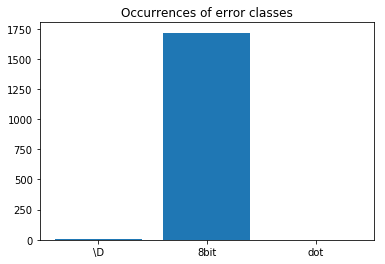

In [93]:
%matplotlib inline

ys = [troff_runner.no_backslash_d_failures,
      troff_runner.no_8bit_failures,
      troff_runner.no_dot_failures]

import matplotlib.pyplot as plt
plt.bar(["\\D", "8bit", "dot"], ys)
plt.title("Occurrences of error classes");


Again, we can see that some inputs (such as the single dot) are very improbable.

### 练习 3: Run Real Troff

Using `BinaryProgramRunner`, apply the fuzzer you configured on the real `troff` program.  Check if you can produce any run whose output code is non-zero, indicating a failure or a crash.

**解决方案.** This is just a matter of putting pieces together.

In [94]:
real_troff_runner = BinaryProgramRunner("troff")
for i in range(100):
    result, outcome = random_fuzzer.run(real_troff_runner)
    if outcome == Runner.FAIL:
        print(result)

Unfortunately, it is very unlikely that you'll find a bug in `troff` at this point.  Like most other open source code, it has been fuzzed this way before – and all errors found are already fixed.